In [1]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline, Model

In [2]:

import ibmos2spark

# @hidden_cell
credentials = {
    'auth_url': 'https://identity.open.softlayer.com',
    'project_id': 'f2a24a66cdc341609d1981c7a9f59ff1',
    'region': 'dallas',
    'user_id': 'f42600a2d0434be5b2467f29dacb1c80',
    'username': 'member_717dbec4da36c47dbc67250b4877af401786b4d3',
    'password': 'b]WZs,l4(4#Hinu-'
}

configuration_name = 'os_5f070ff2bf8948378f720eb9b94c28e2_configs'
bmos = ibmos2spark.bluemix(sc, credentials, configuration_name)

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(bmos.url('Tennis', 'tennis.csv'))
df.take(5)


[Row(Outlook=u'sunny', Temperature=u'hot', Humidity=u'high', Wind=u'strong', Play=u'no'),
 Row(Outlook=u'sunny', Temperature=u'hot', Humidity=u'high', Wind=u'weak', Play=u'no'),
 Row(Outlook=u'overcast', Temperature=u'hot', Humidity=u'high', Wind=u'weak', Play=u'yes'),
 Row(Outlook=u'rain', Temperature=u'mild', Humidity=u'high', Wind=u'weak', Play=u'yes'),
 Row(Outlook=u'rain', Temperature=u'cool', Humidity=u'normal', Wind=u'weak', Play=u'yes')]

In [3]:
df.show()

+--------+-----------+--------+------+----+
| Outlook|Temperature|Humidity|  Wind|Play|
+--------+-----------+--------+------+----+
|   sunny|        hot|    high|strong|  no|
|   sunny|        hot|    high|  weak|  no|
|overcast|        hot|    high|  weak| yes|
|    rain|       mild|    high|  weak| yes|
|    rain|       cool|  normal|  weak| yes|
|    rain|       cool|  normal|strong|  no|
|overcast|       cool|  normal|strong| yes|
|   sunny|       mild|    high|  weak|  no|
|   sunny|       cool|  normal|  weak| yes|
|    rain|       mild|  normal|  weak| yes|
|   sunny|       mild|  normal|strong| yes|
|overcast|       mild|    high|strong| yes|
|overcast|        hot|  normal|  weak| yes|
|    rain|       mild|    high|strong|  no|
+--------+-----------+--------+------+----+



In [4]:
df.printSchema()

root
 |-- Outlook: string (nullable = true)
 |-- Temperature: string (nullable = true)
 |-- Humidity: string (nullable = true)
 |-- Wind: string (nullable = true)
 |-- Play: string (nullable = true)



In [5]:
df.toPandas().describe()

,Outlook,Temperature,Humidity,Wind,Play
count,14,14,14,14,14
unique,3,3,2,2,2
top,rain,mild,normal,weak,yes
freq,5,6,7,8,9


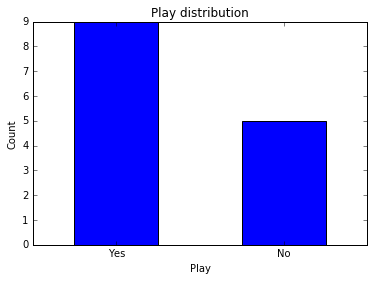

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

df2 = df.toPandas()
count_play = pd.value_counts(df2['Play'], sort = True)
count_play.plot(kind = 'bar', rot=0)
plt.title("Play distribution")
plt.xticks(range(2), ["Yes", "No"])
plt.xlabel("Play")
plt.ylabel("Count");

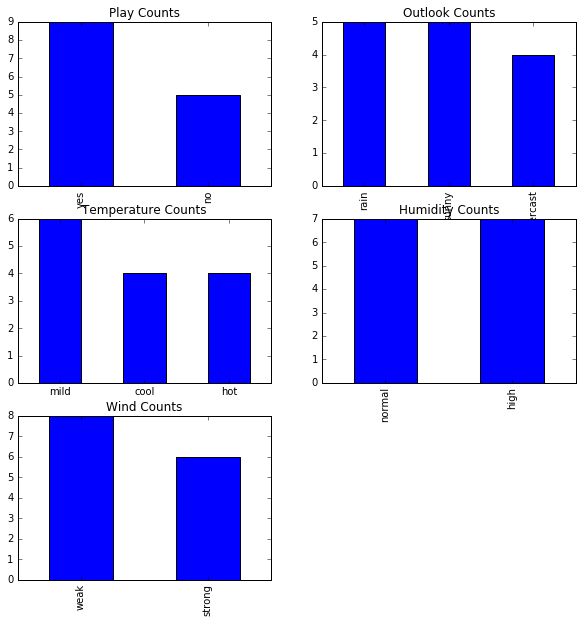

In [7]:
# Set up a grid of plots
fig = plt.figure(figsize=(10, 10)) 
fig_dims = (3, 2)

# Plot play counts
plt.subplot2grid(fig_dims, (0, 0))
df2['Play'].value_counts().plot(kind='bar', 
                                         title='Play Counts')

# Plot Outlook counts
plt.subplot2grid(fig_dims, (0, 1))
df2['Outlook'].value_counts().plot(kind='bar', 
                                       title='Outlook Counts')

# Plot Temperature counts
plt.subplot2grid(fig_dims, (1, 0))
df2['Temperature'].value_counts().plot(kind='bar', 
                                    title='Temperature Counts')
plt.xticks(rotation=0)

# Plot Embarked counts
plt.subplot2grid(fig_dims, (1, 1))
df2['Humidity'].value_counts().plot(kind='bar', 
                                         title='Humidity Counts')

# Plot Wind counts
plt.subplot2grid(fig_dims, (2, 0))
df2['Wind'].value_counts().plot(kind='bar', 
                                         title='Wind Counts')

plt.show()

In [8]:
splitted_data = df.randomSplit([0.85, 0.15], 48)
train_data = splitted_data[0]
test_data = splitted_data[1]

In [9]:
stringIndexer_label = StringIndexer(inputCol="Play", outputCol="label").fit(df)
stringIndexer_outlook = StringIndexer(inputCol="Outlook", outputCol="outlook_code")
stringIndexer_temp = StringIndexer(inputCol="Temperature", outputCol="temperature_code")
stringIndexer_humi = StringIndexer(inputCol="Humidity", outputCol="humidity_code")
stringIndexer_wind = StringIndexer(inputCol="Wind", outputCol="wind_code")

In [10]:
vectorAssembler_features = VectorAssembler(inputCols=["outlook_code", "temperature_code", "humidity_code", "wind_code"], outputCol="features")
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

In [11]:
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=stringIndexer_label.labels)

In [12]:
pipeline_dt = Pipeline(stages=[stringIndexer_label, stringIndexer_outlook, stringIndexer_temp, stringIndexer_humi, stringIndexer_wind, vectorAssembler_features, dt, labelConverter])

In [21]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes
from com.ibm.analytics.wml.cads import CADSEstimator
from com.ibm.analytics.wml.cads import Learner, Target

lr = LogisticRegression(labelCol="label", featuresCol="features", regParam=0.01)
nb = NaiveBayes(labelCol="label", featuresCol="features", smoothing=1.0)

learners = [Learner("LR", lr), Learner("NB", nb)]
cads = CADSEstimator().setLearners(learners)\
        .setEvaluator(MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"))\
        .setTarget(Target("prediction", "label"))\
        .setInitialSampleSize(2)\
        .setNumSampleFolds(2)\
        .setKeepBestNLearners(2)
               
pipeline_dt = Pipeline(stages=[stringIndexer_label, stringIndexer_outlook, stringIndexer_temp, stringIndexer_humi, stringIndexer_wind, vectorAssembler_features, cads, labelConverter])

In [22]:
model_dt = pipeline_dt.fit(train_data)

In [15]:
model_dt.stages[-2]

CADS-Score_b0a520ded387

In [16]:
predictions = model_dt.transform(test_data)
evaluatorDT = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
accuracy = evaluatorDT.evaluate(predictions)

print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 1
Test Error = 0


In [17]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = predictions.select(['probability', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is: ", metrics.areaUnderROC)


('The ROC score is: ', 1.0)


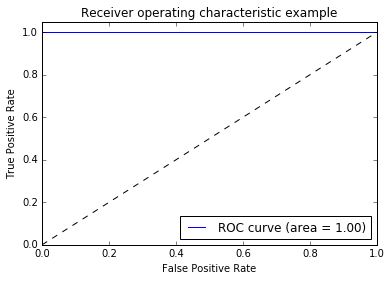

In [18]:
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [19]:
new_data = [{'Outlook': 'rain', 'Temperature': 'hot', 'Humidity': 'normal', 'Wind': 'strong'},
            {'Outlook': 'sunny', 'Temperature': 'mild', 'Humidity': 'normal', 'Wind': 'weak'}]

new_df = sqlContext.createDataFrame(new_data)
new_df.show()

+--------+-------+-----------+------+
|Humidity|Outlook|Temperature|  Wind|
+--------+-------+-----------+------+
|  normal|   rain|        hot|strong|
|  normal|  sunny|       mild|  weak|
+--------+-------+-----------+------+



/usr/local/src/spark20master/spark/python/pyspark/sql/session.py:316: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


In [20]:
new_predictions = model_dt.transform(new_df)
new_predictions.select("predictedLabel").show()

+--------------+
|predictedLabel|
+--------------+
|           yes|
|           yes|
+--------------+

